# Introduction
**Authors:** Thinh RE <br>
**Name:** CartPole with Deep Q Network <br>
**Date created:** 18/05/2022<br>
**Last modified:** 20/05/2022<br>
**Description:** 



# Initialization

## Setup

In [1]:
%%bash
# This Cell is only used to make sure cartpole runs 

# install required system dependencies
apt-get install -y xvfb x11-utils

# install required python dependencies (might need to install additional gym extras depending)
pip install pyvirtualdisplay PyOpenGL PyOpenGL-accelerate

Reading package lists...
Building dependency tree...
Reading state information...
x11-utils is already the newest version (7.7+3build1).
xvfb is already the newest version (2:1.19.6-1ubuntu4.10).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 42 not upgraded.


In [2]:
# This Cell is only used to make sure cartpole runs 

import pyvirtualdisplay


_display = pyvirtualdisplay.Display(visible=False,  # use False with Xvfb
                                    size=(1400, 900))
_ = _display.start()

## Import

In [20]:
from typing import Union, Tuple, List
from torch import Tensor

import gym
import collections
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import os
import matplotlib.pyplot as plt

from tqdm import tqdm

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cpu_device = torch.device('cpu')

In [4]:
env = gym.make('CartPole-v0')
env.reset()

array([-0.03663349, -0.01738151, -0.00109183,  0.00652503])

In [5]:
seed: int = 742
torch.manual_seed(seed)
env.seed(seed)
random.seed(seed)
np.random.seed(seed)
env.action_space.seed(seed)

[742]

## Hyperparameters

In [6]:
learning_rate = 0.0005
gamma         = 0.98
buffer_limit  = 50000
batch_size    = 100
print_every   = 50

## ReplayBuffer

In [7]:
class ReplayBuffer:
  def __init__(self):
    self.buffer = collections.deque(maxlen=buffer_limit)
  
  def put(self, transition)->None:
    self.buffer.append(transition)
  
  def sample(self, n: int)->Tuple[Tensor, Tensor, Tensor, Tensor, Tensor]:
    '''
    Returns: Tensors of state, action, reward, next state, is done
    '''
    mini_batch = random.sample(self.buffer, n)
    s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = [], [], [], [], []
    
    for transition in mini_batch:
      s, a, r, s_prime, done_mask = transition
      s_lst.append(s)
      a_lst.append([a])
      r_lst.append([r])
      s_prime_lst.append(s_prime)
      done_mask_lst.append([done_mask])

    s_lst, a_lst, r_lst, s_prime_lst, done_mask_lst = np.array(s_lst), np.array(a_lst), np.array(r_lst), np.array(s_prime_lst), np.array(done_mask_lst)

    return torch.tensor(s_lst, dtype=torch.float), torch.tensor(a_lst), \
      torch.tensor(r_lst), torch.tensor(s_prime_lst, dtype=torch.float), \
      torch.tensor(done_mask_lst)
  
  def size(self)->int:
    return len(self.buffer)

## Q-Net

In [8]:
class QNetwork(nn.Module):
  def __init__(self, insize: int, outsize: int):
    super(QNetwork, self).__init__()
    self.fc1 = nn.Linear(insize, 256)
    self.fc2 = nn.Linear(256, 84)
    self.fc3 = nn.Linear(84, outsize)

    self.he_initialization(self.fc1)
    self.he_initialization(self.fc2)
    self.he_initialization(self.fc3)
      

  def he_initialization(self, layer: nn.Linear)->None:
    torch.nn.init.xavier_uniform_(layer.weight)
    layer.bias.data.fill_(0.01)

  def forward(self, x: Tensor)->Tensor:
    x = x.view(x.size(0),-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x
    
  def sample_action(self, obs: Tensor, epsilon: float)->int:
    '''
    Discrete action 1 or 0
    '''
    out = self.forward(obs)
    coin = random.random()
    if coin < epsilon:
      return random.randint(0,1)
    else : 
      return out.argmax().item()

## Train function

In [9]:
def train(q: QNetwork, q_target: QNetwork, memory: ReplayBuffer, optimizer: optim.Adam):
  for i in range(10):
    optimizer.zero_grad()

    s,a,r,s_prime,done_mask = memory.sample(batch_size)

    s = s.to(device)
    a = a.to(device)
    s_prime = s_prime.to(device)
    r = r.to(device)
    done_mask = done_mask.to(device)

    q_out = q(s) # (b, 2)
    q_a = q_out.gather(1,a) # (b,2) (b,1) => (b, 1)
    max_q_prime = q_target(s_prime).max(1)[0].unsqueeze(1)
    
    # Q(s,a) = R(s,a) + γ*Q_targ(s_prime)*done_mask
    target = r + gamma * max_q_prime * done_mask

    # print('q_out', q_out.size())
    # print('a', a.size())
    # print('q_a', q_a.size())
    # print('max_q_prime', max_q_prime.size())
    # print('r', r.size())
    # print('target', target.size())

    loss = F.smooth_l1_loss(q_a, target)
    
    loss.backward()
    optimizer.step()

# Train

In [28]:
def grid_search(
  epsilon: float, 
  q: QNetwork = None, 
  scores: List[float] = None,
  no_episodes: int = 1001,
)->Tuple[QNetwork, List[float]]: 
  if q is None:
    q = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
  
  # if os.path.isfile('ckpt.pth'):
  #   q.load_state_dict(torch.load('ckpt.pth'))
  q_target = QNetwork(np.array(env.observation_space.shape).prod(), env.action_space.n)
  q.to(device)
  q_target.to(device)
  q_target.load_state_dict(q.state_dict())
  memory = ReplayBuffer()

  score: float = 0.0
  if scores is None:
    scores: List[float] = []
  marking: float  = []
  optimizer = optim.Adam(q.parameters(), lr=learning_rate)

  for n_episode in range(no_episodes):
    # epsilon: float = epsilon # max(0.01, 0.08 - 0.01*(n_episode/200)) # linear annealing from 8% to 1%
    s: np.ndarray = env.reset() # (4,)
    done: bool = False
    score: float = 0.0

    while True:
      obs: Tensor = torch.from_numpy(s).float().unsqueeze(0) # (1, 4)
      obs = obs.to(device)
      a = q.sample_action(obs, epsilon)
      s_prime, r, done, _ = env.step(a)
      done_mask = 0.0 if done else 1.0
      memory.put((s,a,r/100.0,s_prime, done_mask))
      s: np.ndarray = s_prime

      score += r
      if done:
        break
        
    if memory.size()>2000:
      train(q, q_target, memory, optimizer)

    marking.append(score)
    scores.append(score)

    if n_episode%100 == 0:
      print("marking, episode: {}, score: {:.1f}, mean_score: {:.2f}, std_score: {:.2f}".format(
        n_episode, score, np.array(marking).mean(), np.array(marking).std()))
      marking = []

    # you can change this part, and print any data you like (so long as it doesn't start with "marking")
    if n_episode%print_every==0 and n_episode!=0:
      q_target.load_state_dict(q.state_dict())
      # print("episode: {}, score: {:.1f}, epsilon: {:.2f}".format(n_episode, score, epsilon))

  if memory.size() > 0:
    train(q, q_target, memory, optimizer)

  torch.save(q.state_dict(), f'{epsilon}-ckpt.pth')

  return q, scores

In [11]:
epsilons: List[float] = [0.05, 0.01, 0.1, 0.5]
colors: List[str] = ['b', 'g', 'r', 'c']
lst_scores: List[List[float]] = []
qnets: List[QNetwork] = []
for epsilon in tqdm(epsilons):
  q, scores = grid_search(epsilon)
  q.to(cpu_device)
  lst_scores.append(scores)
  qnets.append(q)

marking, episode: 0, score: 9.0, mean_score: 9.00, std_score: 0.00
episode: 50, score: 8.0, epsilon: 0.05
marking, episode: 100, score: 8.0, mean_score: 9.58, std_score: 1.01
episode: 100, score: 8.0, epsilon: 0.05
episode: 150, score: 10.0, epsilon: 0.05
marking, episode: 200, score: 9.0, mean_score: 9.61, std_score: 1.11
episode: 200, score: 9.0, epsilon: 0.05
episode: 250, score: 9.0, epsilon: 0.05
marking, episode: 300, score: 9.0, mean_score: 9.47, std_score: 0.95
episode: 300, score: 9.0, epsilon: 0.05
episode: 350, score: 11.0, epsilon: 0.05
marking, episode: 400, score: 18.0, mean_score: 11.49, std_score: 2.33
episode: 400, score: 18.0, epsilon: 0.05
episode: 450, score: 16.0, epsilon: 0.05
marking, episode: 500, score: 40.0, mean_score: 29.78, std_score: 16.86
episode: 500, score: 40.0, epsilon: 0.05
episode: 550, score: 44.0, epsilon: 0.05
marking, episode: 600, score: 51.0, mean_score: 79.07, std_score: 47.16
episode: 600, score: 51.0, epsilon: 0.05
episode: 650, score: 79.0

# Calculate best score (greedy)

In [12]:
def simulate_greedy(q: QNetwork)->float:
  s: np.ndarray = env.reset() # (4,)
  q.to(device)
  done: bool = False
  score: float = 0.0
  while True:
    obs: Tensor = torch.from_numpy(s).float().unsqueeze(0) # (1, 4)
    obs = obs.to(device)
    a = q.sample_action(obs, 0.0)
    s_prime, r, done, _ = env.step(a)
    s: np.ndarray = s_prime

    score += r
    if done:
      break

  q.to(cpu_device)
  return score

# Plot scores

In [13]:
def moving_average(a: Union[List[float], np.ndarray], n: int = 3)->np.ndarray:
  ret = np.cumsum(a, dtype=float)
  ret[n:] = ret[n:] - ret[:-n]
  return ret[n - 1:] / n

In [35]:
def plot_scores():
  plt.figure(figsize=(20, 12))

  for epsilon, scores, q, c in tqdm(zip(epsilons, lst_scores, qnets, colors)):
    moving_avg_scores = moving_average(scores, 50)
    greedy_score = simulate_greedy(q)
    plt.plot(np.arange(len(moving_avg_scores)), moving_avg_scores, color=c, label=f'epsilon={epsilon},greedy_score={greedy_score}')

  plt.xlabel('Iteration(s)')
  plt.ylabel('Average reward')
  plt.legend()
  plt.show()

In [ ]:
plot_scores()

# Continue training

In [33]:
new_lst_scores: List[List[float]] = []
no_episodes = 100

for epsilon, scores, q in tqdm(zip(epsilons, lst_scores, qnets)):
  q, scores = grid_search(epsilon, q, scores, no_episodes = no_episodes)
  q.to(cpu_device)
  new_lst_scores.append(scores)
  qnets.append(q)

lst_scores = new_lst_scores

0it [00:00, ?it/s]

marking, episode: 0, score: 132.0, mean_score: 132.00, std_score: 0.00


1it [00:05,  5.88s/it]

marking, episode: 0, score: 200.0, mean_score: 200.00, std_score: 0.00


2it [00:13,  6.83s/it]

marking, episode: 0, score: 200.0, mean_score: 200.00, std_score: 0.00


3it [00:20,  7.16s/it]

marking, episode: 0, score: 21.0, mean_score: 21.00, std_score: 0.00


4it [00:21,  5.36s/it]


4it [00:00, 21.53it/s]


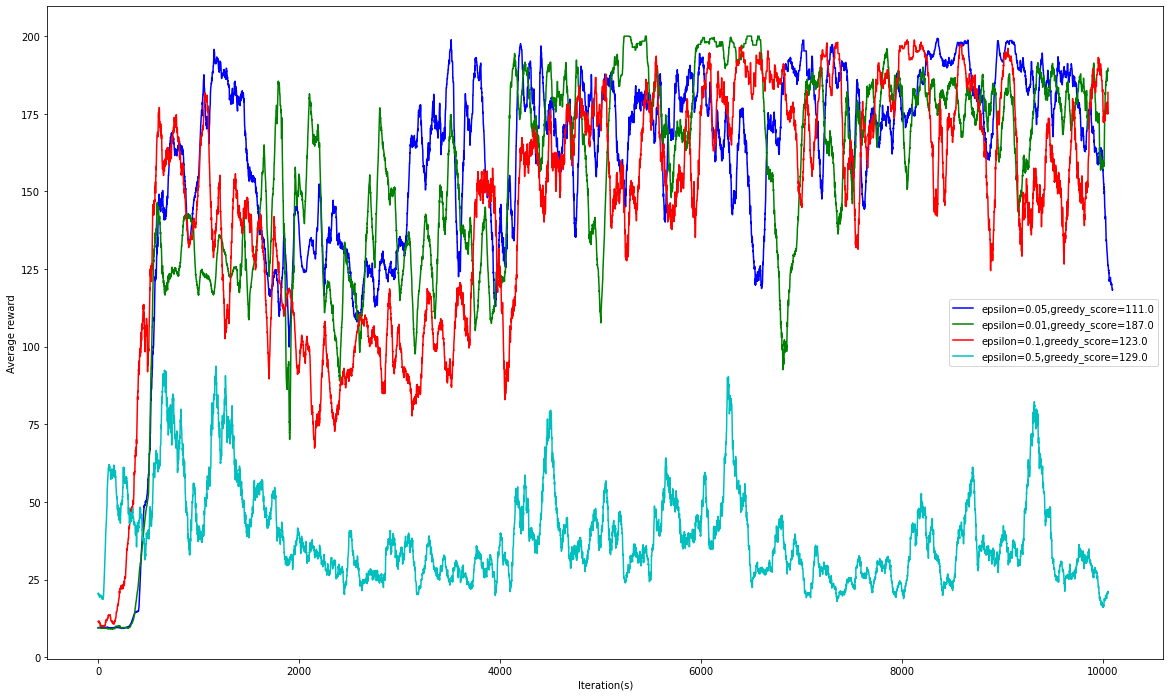

In [36]:
plot_scores()